In [1]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]

clearall()

In [2]:
from matplotlib import pyplot as plt
from pandas import json_normalize
import json
import pandas as pd
from tqdm import tqdm
import requests
import time
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
from scipy import optimize

import cvxopt as opt
from cvxopt import blas, solvers
solvers.options['show_progress'] = False

sns.set(rc={'figure.figsize':(11, 4)})

In [3]:
bitcoin = pd.read_csv('data/csv/btc.csv', index_col=0)

bitcoin = pd.DataFrame(bitcoin["ReferenceRate"])

bitcoin = bitcoin.rename(columns={'ReferenceRate': 'BITCOIN'})
bitcoin.index = bitcoin.index.rename('date')
bitcoin.index = pd.to_datetime(bitcoin.index)

bitcoin.tail()

/var/folders/d2/1qh2h9ys19z3375prb_0cb8w0000gn/T/ipykernel_3505/2310037391.py:1: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  bitcoin = pd.read_csv('data/csv/btc.csv', index_col=0)


,BITCOIN
date,
2024-09-13,58124.641807
2024-09-14,60536.881450
2024-09-15,60007.170251
2024-09-16,59129.919754
2024-09-17,58227.464217


In [4]:
high_risk = pd.read_csv('out/1W/btc_parity_HIGH_RISK_stress_2.xlsx_Parity.csv', index_col=0)

weight_high_risk = pd.DataFrame(high_risk["1_weight"])
high_risk = pd.DataFrame(high_risk["Portfolio Value"])

high_risk = high_risk.rename(columns={'Portfolio Value': 'HIGH'})
high_risk.index = high_risk.index.rename('date')
high_risk.index = pd.to_datetime(high_risk.index)

weight_high_risk = weight_high_risk.rename(columns={'1_weight': 'WEIGHT'})
weight_high_risk.index = weight_high_risk.index.rename('date')
weight_high_risk.index = pd.to_datetime(weight_high_risk.index)

high_risk

,HIGH
date,
2021-06-26,10000.000000
2021-06-27,10028.279925
2021-06-28,10457.369963
2021-06-29,10433.590408
2021-06-30,10678.829983
...,...
2024-06-22,24141.850510
2024-06-23,24183.260496
2024-06-24,24183.260496


In [5]:
medium_risk = pd.read_csv(
    "out/1W/btc_parity_MEDIUM_RISK_stress_2.xlsx_Parity.csv", index_col=0
)

weight_medium_risk = pd.DataFrame(medium_risk["1_weight"])
medium_risk = pd.DataFrame(medium_risk["Portfolio Value"])

medium_risk = medium_risk.rename(columns={'Portfolio Value': 'MEDIUM'})
medium_risk.index = medium_risk.index.rename('date')
medium_risk.index = pd.to_datetime(medium_risk.index)

weight_medium_risk = weight_medium_risk.rename(columns={'1_weight': 'WEIGHT'})
weight_medium_risk.index = weight_medium_risk.index.rename('date')
weight_medium_risk.index = pd.to_datetime(weight_medium_risk.index)

medium_risk

,MEDIUM
date,
2021-06-26,10000.000000
2021-06-27,10020.858238
2021-06-28,10370.644722
2021-06-29,10350.334524
2021-06-30,10546.300204
...,...
2024-06-22,23016.722804
2024-06-23,23050.962137
2024-06-24,23050.962137


In [6]:
# start_time = high_risk.index[0]
# end_time = high_risk.index[-1]

start_time = pd.Timestamp('2022-04-01 00:00:00')
end_time = pd.Timestamp('2024-04-01 00:00:00')

bitcoin = bitcoin[bitcoin.index >= start_time]
bitcoin = bitcoin[bitcoin.index <= end_time]

years = (end_time - start_time).days/365
risk_free_rate = 3/100

In [7]:
high_risk = high_risk[high_risk.index >= start_time]
high_risk = high_risk[high_risk.index <= end_time]

medium_risk = medium_risk[medium_risk.index >= start_time]
medium_risk = medium_risk[medium_risk.index <= end_time]

weight_high_risk = weight_high_risk[weight_high_risk.index >= start_time]
weight_high_risk = weight_high_risk[weight_high_risk.index <= end_time]

weight_medium_risk = weight_medium_risk[weight_medium_risk.index >= start_time]
weight_medium_risk = weight_medium_risk[weight_medium_risk.index <= end_time]

In [8]:
bitcoin_total_return = (bitcoin["BITCOIN"].iloc[-1]/bitcoin["BITCOIN"].iloc[0]) - 1
# bitcoin_total_return = (1 + bitcoin_total_return)**(1/years) - 1
bitcoin_total_return = bitcoin_total_return/years

bitcoin_daily_return = bitcoin["BITCOIN"].pct_change(periods=1)
bitcoin_average_daily_return = bitcoin_daily_return.mean()
bitcoin_daily_return_volatility = bitcoin_daily_return.std()
bitcoin_volatility = bitcoin_daily_return_volatility*np.sqrt(365)

bitcoin_running_max = np.maximum.accumulate(bitcoin["BITCOIN"]/bitcoin["BITCOIN"].iloc[0])
bitcoin_running_max[bitcoin_running_max < 1] = 1

bitcoin_drawdown = bitcoin["BITCOIN"]/bitcoin["BITCOIN"].iloc[0]/bitcoin_running_max - 1
bitcoin_max_drawdown = -bitcoin_drawdown.min()

bitcoin_sharpe = (bitcoin_average_daily_return - risk_free_rate/365)/bitcoin_daily_return_volatility
bitcoin_sharpe = bitcoin_sharpe*np.sqrt(365)
bitcoin_calmar = (bitcoin_total_return - risk_free_rate)/bitcoin_max_drawdown

print("bitcoin")
print("return", np.round(bitcoin_total_return*100, 1))
print("vol", np.round(bitcoin_volatility*100, 1))
print("max drowdanw", np.round(bitcoin_max_drawdown*100, 1))

print(" ")
print("Sharpe", np.round(bitcoin_sharpe, 2))
print("Calmar", np.round(bitcoin_calmar, 2))

bitcoin
return 28.1
vol 54.0
max drowdanw 66.2
 
Sharpe 0.63
Calmar 0.38


In [9]:
high_risk_total_return = (high_risk["HIGH"].iloc[-1]/high_risk["HIGH"].iloc[0]) - 1
# high_risk_total_return = (1 + high_risk_total_return)**(1/years) - 1
high_risk_total_return = high_risk_total_return/years

high_risk_daily_return = high_risk["HIGH"].pct_change(periods=1)
high_risk_average_daily_return = high_risk_daily_return.mean()
high_risk_daily_return_volatility = high_risk_daily_return.std()
high_risk_volatility = high_risk_daily_return_volatility*np.sqrt(365)

high_risk_running_max = np.maximum.accumulate(high_risk["HIGH"]/high_risk["HIGH"].iloc[0])
high_risk_running_max[high_risk_running_max < 1] = 1

high_risk_drawdown = high_risk["HIGH"]/high_risk["HIGH"].iloc[0]/high_risk_running_max - 1
high_risk_max_drawdown = -high_risk_drawdown.min()

high_risk_sharpe = (high_risk_average_daily_return - risk_free_rate/365)/high_risk_daily_return_volatility
high_risk_sharpe = high_risk_sharpe*np.sqrt(365)
high_risk_calmar = (high_risk_total_return - risk_free_rate)/high_risk_max_drawdown

print("HIGH")
print(np.round(high_risk_total_return*100, 1))
print(np.round(high_risk_volatility*100, 1))
print(np.round(high_risk_max_drawdown*100, 1))

print(" ")
print(np.round(high_risk_sharpe, 2))
print(np.round(high_risk_calmar, 2))

HIGH
50.2
41.1
46.6
 
0.98
1.01


In [10]:
medium_risk_total_return = (medium_risk["MEDIUM"].iloc[-1]/medium_risk["MEDIUM"].iloc[0]) - 1
# medium_risk_total_return = (1 + medium_risk_total_return)**(1/years) - 1
medium_risk_total_return = medium_risk_total_return/years

medium_risk_daily_return = medium_risk["MEDIUM"].pct_change(periods=1)
medium_risk_average_daily_return = medium_risk_daily_return.mean()
medium_risk_daily_return_volatility = medium_risk_daily_return.std()
medium_risk_volatility = medium_risk_daily_return_volatility*np.sqrt(365)

medium_risk_running_max = np.maximum.accumulate(medium_risk["MEDIUM"]/medium_risk["MEDIUM"].iloc[0])
medium_risk_running_max[medium_risk_running_max < 1] = 1

medium_risk_drawdown = medium_risk["MEDIUM"]/medium_risk["MEDIUM"].iloc[0]/medium_risk_running_max - 1
medium_risk_max_drawdown = -medium_risk_drawdown.min()

medium_risk_sharpe = (medium_risk_average_daily_return - risk_free_rate/365)/medium_risk_daily_return_volatility
medium_risk_sharpe = medium_risk_sharpe*np.sqrt(365)
medium_risk_calmar = (medium_risk_total_return - risk_free_rate)/medium_risk_max_drawdown

print("MEDIUM")
print(np.round(medium_risk_total_return*100, 1))
print(np.round(medium_risk_volatility*100, 1))
print(np.round(medium_risk_max_drawdown*100, 1))

print(" ")
print(np.round(medium_risk_sharpe, 2))
print(np.round(medium_risk_calmar, 2))

MEDIUM
47.5
36.7
41.1
 
1.01
1.08


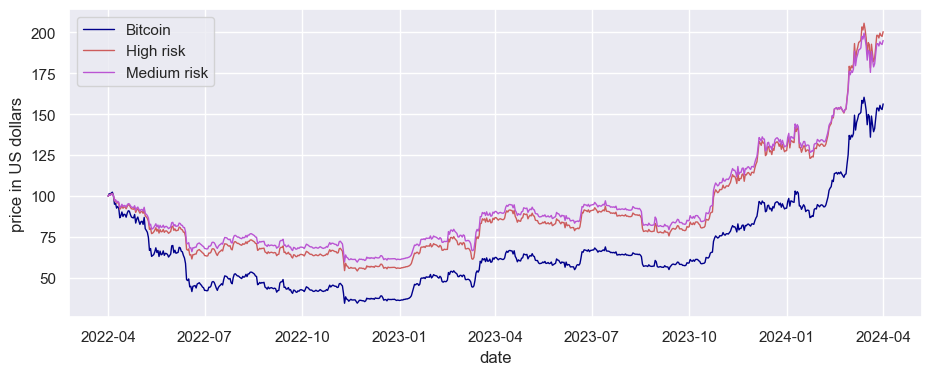

In [11]:
plt.plot(100*bitcoin/bitcoin.iloc[0], label="Bitcoin", linewidth=1, color="darkblue")

plt.plot(100*high_risk/high_risk.iloc[0], label="High risk", linewidth=1, color="indianred")
plt.plot(100*medium_risk/medium_risk.iloc[0], label="Medium risk", linewidth=1, color="mediumorchid")
plt.xlabel("date")
plt.ylabel("price in US dollars")
plt.legend()
plt.show()

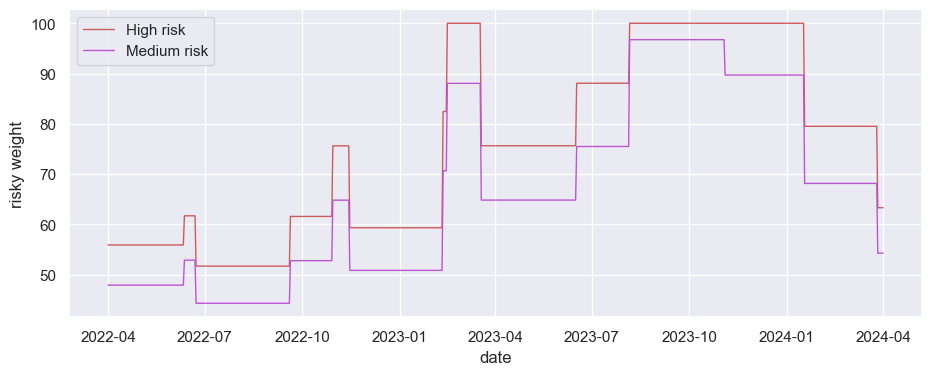

In [12]:
plt.plot(100*(1-weight_high_risk), label="High risk", linewidth=1, color="indianred")
plt.plot(100*(1-weight_medium_risk), label="Medium risk", linewidth=1, color="mediumorchid")
plt.xlabel("date")
plt.ylabel("risky weight")
plt.legend()
plt.show()

In [13]:
print((np.abs((1-weight_high_risk).pct_change(periods=1))[1:] > 0.0).sum().iloc[0])
print((np.abs((1-weight_medium_risk).pct_change(periods=1))[1:] > 0.0).sum().iloc[0])

12
13


In [14]:
rebalancing_high_risk = weight_high_risk[(np.abs((1-weight_high_risk).pct_change(periods=1)) > 0.0).to_numpy()].index
rebalancing_high_risk

DatetimeIndex(['2022-06-12', '2022-06-23', '2022-09-20', '2022-10-30',
               '2022-11-15', '2023-02-11', '2023-02-15', '2023-03-19',
               '2023-06-17', '2023-08-06', '2024-01-18', '2024-03-27'],
              dtype='datetime64[ns]', name='date', freq=None)

In [15]:
rebalancing_medium_risk = weight_medium_risk[(np.abs((1-weight_medium_risk).pct_change(periods=1)) > 0.0).to_numpy()].index
rebalancing_medium_risk

DatetimeIndex(['2022-06-12', '2022-06-23', '2022-09-20', '2022-10-30',
               '2022-11-15', '2023-02-11', '2023-02-15', '2023-03-19',
               '2023-06-17', '2023-08-06', '2023-11-04', '2024-01-18',
               '2024-03-27'],
              dtype='datetime64[ns]', name='date', freq=None)

In [16]:
# TOY EXAMPLE

span = 3*30  # 3-months volatility
smoothing = 7  # smoothing factor

# il nous faut (span+delay+smoothing) returns

returns = bitcoin[-(span+1+smoothing):].pct_change()

len(returns)

98

In [17]:
# on a (smoothing + 1) volatility

volatility_raw = returns.rolling(span).std()*np.sqrt(365)
volatility_raw

,BITCOIN
date,
2023-12-26,NaN
2023-12-27,NaN
2023-12-28,NaN
2023-12-29,NaN
2023-12-30,NaN
...,...
2024-03-28,0.606276
2024-03-29,0.605570
2024-03-30,0.606794


In [18]:
# on smooth la volatilité, on en a normalement 2 (un seul suffit en réalité)

volatility = volatility_raw.rolling(smoothing).mean()
volatility

,BITCOIN
date,
2023-12-26,NaN
2023-12-27,NaN
2023-12-28,NaN
2023-12-29,NaN
2023-12-30,NaN
...,...
2024-03-28,NaN
2024-03-29,NaN
2024-03-30,NaN


In [19]:
# on prend le dernier point et on a notre vol smoothed, qu'on utilisera à chaque fois

print(np.round(volatility["BITCOIN"].iloc[-1]*100, 2))

60.63


In [20]:
# version vectorisée

returns = bitcoin.pct_change()
volatility_raw = returns.rolling(span).std()*np.sqrt(365)
volatility = volatility_raw.rolling(smoothing).mean()

In [21]:
rebalancing_medium_risk

DatetimeIndex(['2022-06-12', '2022-06-23', '2022-09-20', '2022-10-30',
               '2022-11-15', '2023-02-11', '2023-02-15', '2023-03-19',
               '2023-06-17', '2023-08-06', '2023-11-04', '2024-01-18',
               '2024-03-27'],
              dtype='datetime64[ns]', name='date', freq=None)

In [22]:
# on se focalise sur le medium et on a une date de rebalancement (triggered) le 2023-02-11
# la vol non-smoothed (à ne pas utiliser) est donnée par:

vol_raw_old = volatility_raw[volatility_raw.index == rebalancing_high_risk[6]]
vol_raw_old

,BITCOIN
date,
2023-02-15,0.388983


In [23]:
# et la vol smoothed par (c'est la vol old, car elle correspond à la vol de la dernière date de rebalancing):

vol_old = volatility[
    volatility.index == rebalancing_high_risk[6]
]
vol_old

,BITCOIN
date,
2023-02-15,0.39073


In [24]:
# on regarde la vol lors de la date de rebalancement suivante, le 2023-03-26

current_vol = volatility[
    volatility.index == rebalancing_high_risk[7] - pd.Timedelta(days=1) # il faut regarder le jour d'avant, celui qui a trigger le rebalancement.
]
current_vol

,BITCOIN
date,
2023-03-18,0.501521


In [25]:
# on vérifie que la difference en valeur absolue correspond à notre threshold (10 ou 15%)

np.abs(current_vol["BITCOIN"].iloc[0] - vol_old["BITCOIN"].iloc[0])

0.11079111919893037

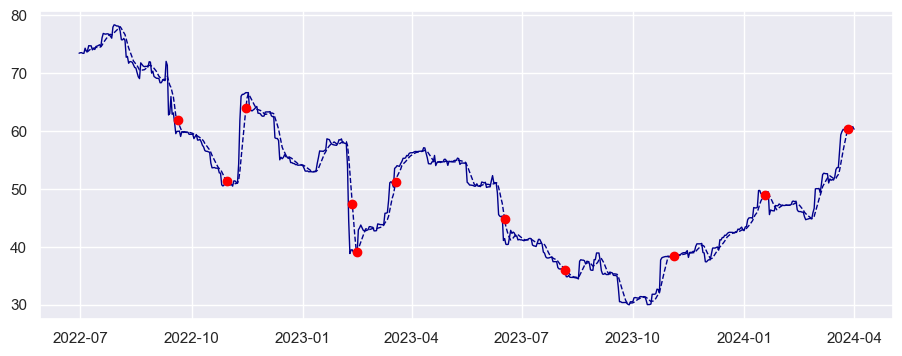

In [26]:
plt.plot(100*volatility_raw, linewidth=1, color="darkblue")
plt.plot(100*volatility, "--", linewidth=1, color="darkblue")
plt.plot(100*volatility[volatility.index.isin(rebalancing_medium_risk)], "o", linewidth=1, color="red")
#plt.plot(100*volatility_raw[volatility_raw.index.isin(rebalancing_medium_risk)], "o", linewidth=0.01, color="red")
plt.show()

In [27]:
# lors de la seconde date de rebalancement (2023-03-26), le poids du risky asset est donné par:

(
    1
    - weight_medium_risk[
        volatility.index == rebalancing_high_risk[6]
    ]
)

,WEIGHT
date,
2023-02-15,0.880463


In [28]:
# et la vol était de:

current_vol = volatility[
    volatility.index == rebalancing_high_risk[6]
]
current_vol

,BITCOIN
date,
2023-02-15,0.39073


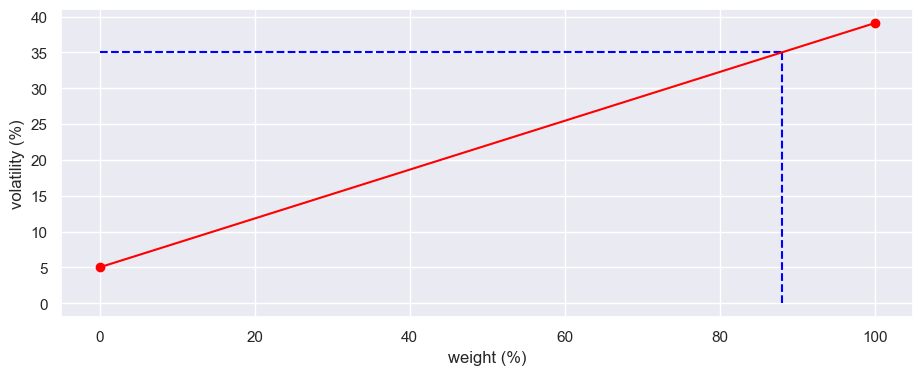

In [29]:
cap = 100/100
floor = 0/100

# la target vol doit être renseignée

target_vol = 35/100

vol_riskless = 5/100
vol_risky = current_vol["BITCOIN"].iloc[0]

target_weight = np.minimum(np.maximum((target_vol - vol_riskless)/(vol_risky - vol_riskless), floor), cap)

weight = np.array([0/100, 100/100])
vol = np.array([vol_riskless, vol_risky])

plt.hlines(y=target_vol*100, xmin=0.0, xmax=target_weight*100, linestyle='--', color="blue")
plt.vlines(x=target_weight*100, ymin=0.0, ymax=target_vol*100, linestyle='--', color="blue")
plt.plot(weight*100, vol*100, "o-", color="red")
plt.xlabel("weight (%)")
plt.ylabel("volatility (%)")
plt.show()

In [30]:
# on doit récupérer ce poids (risky allocation) pour le bon niveau de vol target

print(np.round(target_weight*100, 2))

88.05
